In [21]:
import os
from pathlib import Path
import json
import lmdb
import base64
from io import BytesIO
from PIL import Image
import torch
from tqdm import tqdm
from clip import _tokenizer
from clip.clip import tokenize
from clip.model import convert_weights, CLIP
from torchvision.transforms import Compose, Resize, ToTensor, Normalize

import pandas as pd
import numpy as np
import math
from PIL import Image
import requests
import matplotlib.pyplot as plt
from IPython.display import display,HTML
from typing import  Optional, List
from collections import defaultdict
import pickle


In [22]:

import lmdb
import pickle
from torch.utils.data import Dataset, DataLoader

from timm.data import create_transform

def _convert_to_rgb(image):
    return image.convert('RGB')


def _preprocess_text(text):
    # adapt the text to Chinese BERT vocab
    text = text.lower().replace("“", "\"").replace("”", "\"")
    return text



class LMDBDataset(Dataset):
    def __init__(self, lmdb_path, split="val", max_txt_length=64, use_augment=False, resolution=224):
        self.lmdb_path = lmdb_path

        # assert LMDB directories exist
        assert os.path.isdir(lmdb_path), "The LMDB directory {} of {} split does not exist!".format(lmdb_path, split)
        lmdb_pairs = os.path.join(lmdb_path, "pairs")
        assert os.path.isdir(lmdb_pairs), "The LMDB directory {} of {} image-text pairs does not exist!".format(lmdb_pairs, split)
        lmdb_imgs = os.path.join(lmdb_path, "imgs")
        assert os.path.isdir(lmdb_imgs), "The LMDB directory {} of {} image base64 strings does not exist!".format(lmdb_imgs, split)

        # open LMDB files
        self.env_pairs = lmdb.open(lmdb_pairs, readonly=True, create=False, lock=False, readahead=False, meminit=False)
        self.txn_pairs = self.env_pairs.begin(buffers=True)
        self.env_imgs = lmdb.open(lmdb_imgs, readonly=True, create=False, lock=False, readahead=False, meminit=False)
        self.txn_imgs = self.env_imgs.begin(buffers=True)

        # fetch number of pairs and images
        self.number_samples = int(self.txn_pairs.get(key=b'num_samples').tobytes().decode('utf-8'))
        self.number_images = int(self.txn_imgs.get(key=b'num_images').tobytes().decode('utf-8'))
        

        super(LMDBDataset, self).__init__()

        # the self.dataset_len will be edited to a larger value by calling pad_dataset()
        self.dataset_len = self.number_samples
        self.global_batch_size = 1 # will be modified to the exact global_batch_size after calling pad_dataset()

        self.split = split
        self.max_txt_length = max_txt_length        

        self.use_augment = use_augment
        self.transform = self._build_transform(resolution)

    def _build_transform(self, resolution):
        if self.split == "train" and self.use_augment:
            transform = create_transform(
                             input_size=resolution,
                             scale=(0.9, 1.0),
                             is_training=True,
                             color_jitter=None,
                             auto_augment='original',
                             interpolation='bicubic',
                             mean=(0.48145466, 0.4578275, 0.40821073),
                             std=(0.26862954, 0.26130258, 0.27577711),
                         )
            transform = Compose(transform.transforms[:-3] + [_convert_to_rgb] + transform.transforms[-3:])
        else:
            transform = Compose([
                Resize((resolution, resolution), interpolation=Image.BICUBIC),
                _convert_to_rgb,
                ToTensor(),
                Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
            ])
        return transform

    def __del__(self):
        if hasattr(self, 'env_pairs'):
            self.env_pairs.close()
        if hasattr(self, 'env_imgs'):
            self.env_imgs.close()

    def __len__(self):
        return self.dataset_len

    def __getitem__(self, index):
        sample_index = index % self.number_samples

        # print("***" * 100 )
        # print("self.lmdb_path: ", self.lmdb_path)
        # print(index)
        # print()
        # print("#" * 10)

        pair = pickle.loads(self.txn_pairs.get("{}".format(sample_index).encode('utf-8')).tobytes())
        image_id, text_id, raw_text = pair

        image_b64 = self.txn_imgs.get("{}".format(image_id).encode('utf-8')).tobytes()
        image_b64 = image_b64.decode(encoding="utf8", errors="ignore")
        image = Image.open(BytesIO(base64.urlsafe_b64decode(image_b64))) # already resized
        image = self.transform(image)

        text = tokenize([_preprocess_text(raw_text)], context_length=self.max_txt_length)[0]
        eos_index = text.numpy().tolist().index(_tokenizer.vocab['[SEP]'])
        return image, text, eos_index


# is_train = True
# use_augment = False
# max_txt_length = 24
# db_path = '/data/1_qunosen/2022/res/CLIP/clip/data/indoor/lmdb/train'
# dataset = LMDBDataset(
#     db_path, 
#     split="train" if is_train else "val",
#     max_txt_length=max_txt_length,
#     use_augment=use_augment if is_train else False,
#     resolution= 224,
#     )



##### 数据集准备

In [7]:
def img2bytes(img_path):
    img = Image.open(img_path) # 访问图片路径
    img_buffer = BytesIO()
    img.save(img_buffer, format=img.format)
    byte_data = img_buffer.getvalue()
    base64_str = base64.b64encode(byte_data) # bytes
    base64_str = base64_str.decode("utf-8") # str
    del img, byte_data
    return base64_str

def gen_cn_clip_data(df, dt_type='train', save_dir = os.getcwd()):
    """ 产生 图片内容及匹配文本数据 """
    
    images_df = []
    texts_dt = []
    imgs_dict = {}
    
    if not os.path.exists(save_dir): os.mkdir(save_dir)
    
    txt_json1 = os.path.join(save_dir, f"{dt_type}_texts.jsonl")
    imgs_tsv = os.path.join(save_dir, f"{dt_type}_imgs.tsv")
    imgdict_js = os.path.join(save_dir, f"{dt_type}_dict.json")
    for i,line in enumerate(df.itertuples()):
        ### 图
        image_id = i
        imgs_dict[image_id] = line[1]
        img_path = line[4]
        # print(img_path)
        img_byte = img2bytes(img_path)
        images_df.append({"img_id": i, "img_content": img_byte})
        ### 文
        text = "".join(line[3].split("|||"))
        text_id = i
        jtxt = {"text_id": text_id, "text": text, "image_ids": [image_id]}
        txt_js = json.dumps(jtxt, ensure_ascii=False)
        print(txt_js, file=open(txt_json1, 'a'))
    
    images_df = pd.DataFrame(images_df)
    print(json.dumps(imgs_dict, indent=True), file=open(imgdict_js, 'w'))
    images_df.to_csv(imgs_tsv, sep="\t", header=None, index=False)


def build_clip_data(root_dir):
    """ 将生成的数据转换为 lmdb格式、并进行保存 """
    import lmdb
    import json
    import pickle
    specified_splits = ['train','valid','test']
    lmdb_dir = os.path.join(root_dir, "lmdb")
    if not os.path.exists(lmdb_dir): os.mkdir(lmdb_dir)
    
    for split in specified_splits:

        # 创建 lmdb 
        lmdb_split_dir = os.path.join(lmdb_dir, split)
        if not os.path.exists(lmdb_split_dir): os.mkdir(lmdb_split_dir)
        lmdb_img = os.path.join(lmdb_split_dir, "imgs")
        lmdb_pairs = os.path.join(lmdb_split_dir, "pairs")
        env_img = lmdb.open(lmdb_img, map_size=1024**4)
        txn_img = env_img.begin(write=True)
        env_pairs = lmdb.open(lmdb_pairs, map_size=1024**4)
        txn_pairs = env_pairs.begin(write=True)
        pairs_annotation_path = os.path.join(root_dir, f"{split}_texts.jsonl")

        # 写入 lmdb 文图配对信息
        with open(pairs_annotation_path, "r") as fin_pairs:
            write_idx = 0
            for line in tqdm(fin_pairs):
                line = line.strip()
                obj = json.loads(line)
                for field in ("text_id", "text", "image_ids"):
                    assert field in obj, "Field {} does not exist in line {}. \
                        Please check the integrity of the text annotation Jsonl file."
                for image_id in obj["image_ids"]:
                    dump = pickle.dumps((image_id, obj['text_id'], obj['text'])) # encoded (image_id, text_id, text)
                    txn_pairs.put(key="{}".format(write_idx).encode('utf-8'), value=dump)  
                    write_idx += 1
                    if write_idx % 5000 == 0:
                        txn_pairs.commit()
                        txn_pairs = env_pairs.begin(write=True)
            txn_pairs.put(key=b'num_samples', value="{}".format(write_idx).encode('utf-8'))
            txn_pairs.commit()
            env_pairs.close()

        print("Finished serializing {} {} split pairs into {}.".format(write_idx, split, lmdb_pairs))

        # 写入 lmdb 字节流图像数据
        base64_path = os.path.join(root_dir, f"{split}_imgs.tsv")
        with open(base64_path, "r") as fin_imgs:
            write_idx = 0
            for line in tqdm(fin_imgs):
                line = line.strip()
                image_id, b64 = line.split("\t")
                txn_img.put(key="{}".format(image_id).encode('utf-8'), value=b64.encode("utf-8"))
                write_idx += 1
                if write_idx % 1000 == 0:
                    txn_img.commit()
                    txn_img = env_img.begin(write=True)
            txn_img.put(key=b'num_images', value="{}".format(write_idx).encode('utf-8'))
            txn_img.commit()
            env_img.close()  
        print("Finished serializing {} {} split images into {}.".format(write_idx, split, lmdb_img))

    print("done !")



def imgGallery(imglist: Optional[List], ids: Optional[List]=None, \
        scores: Optional[List] = None, tags: Optional[List]=None, \
        default_hight: Optional[str]='300px'):

    """ 显示图片：imglist：url列表或图片地址列表  """

    if ids is None:
        ids = []
    if tags is None:
        tags = []
    if scores is None:
        scores = []
    
    figures = []
    for i, img_path in enumerate(imglist):
        mid = ids[i] if ids else ''
        tag = tags[i] if tags else ""
        score = ', score=%.2f' % scores[i] if scores else ""
        file_info = f'<figcaption style="font-size: 1em;"><a target="_blank" href="{img_path}" style="display:inline;margin:1px"/> <br> {mid} {score} </figcaption>'
        desc_img = f'<figcaption style="font-size: 1em;"> <b> {tag} </b> <br> </figcaption>'
        figures.append(
            f"""
                <figure style="margin: 5px !important;">
                    {file_info}
                    <a target="_blank"  style="word-break: normal;"><img src="{img_path}" style="height: {default_hight}"></a>
                    {desc_img}
                </figure>
            """
            )


    return display(HTML(
                    data=f"""
                        <div style="display: flex; flex-flow: row wrap; text-align: center;">
                        {''.join(figures)}
                        </div>
                        """
                ))




##### 原始数据格式

In [23]:

train_captions = [
    ("62042.jpg", "明亮的卧室里有一组沙发和一盏漂亮的水晶吊灯"),
    ("62042.jpg", "卧室里的窗帘是白色的, 地毯是灰色的"),
    ("652403.jpg", "粉色墙面的客厅有两个圆形的茶几"),
    ("652403.jpg", "客厅的地板是石膏线样式的,整体是马卡龙色系"),
    ("652403.jpg", "客厅的地板是灰褐色的,墙面是粉色的"),
    ("652435.jpg", "客厅的吊顶有几何图案,窗帘是白色轻纱的,很漂亮"),
    ("652435.jpg", "粉红色的沙发和墨绿色的椅子很搭配"),
    ("652435.jpg", "客厅背景墙上有一副挂画"),
    ("652435.jpg", "客厅的白色枝形吊灯很好看"),
    ("652435.jpg", "粉色沙发上有3个红色抱枕"),
    ("652435.jpg", "米白色沙发上有2个抱枕"),
    ("653802.jpg", "餐厅有两个白色的圆形吊灯"),
    ("653802.jpg", "石膏线棕色木质地板"),
    ("653802.jpg", "棕色的餐桌和木椅"),
    ("653802.jpg", "厨房的灰色地毯和地板很搭"),
    ("653795.jpg", "书房的吊灯是棕色的,墙面是白色的,地板是棕色的"),
    ("653795.jpg", "蓝色的书架上有很多书"),
    ("653795.jpg", "白色墙面上的挂画很显眼"),
    ("653795.jpg", "墙上有副装饰画"),
    ("653795.jpg", "厨房和书房之间有隔断"),
    ("653795.jpg", "带有隔断的书房很小"),
    ("653794.jpg", "这个吊灯和白色的墙面很协调"),
    ("653794.jpg", "餐桌和餐椅是木质的,柜子是黑色的"),
    ("653794.jpg", "白色的圆拱门很漂亮"),
    ("653790.jpg", "这个棕色的皮质沙发和条纹状地毯很有高级感"),
    ("653928.jpg", "窗帘是红色的，墙是白色的"),
    ("653928.jpg", "白墙上挂着一副红色装饰画"),
    ("653932.jpg", "红色的地毯和红色的窗帘"),
]


test_captions = [  
    ("653791.jpg","厨房有个盏白色的吊灯"),
    ("653791.jpg","厨房墙上挂着很多镜子，镜子对面有个柜子"),
    ("653936.jpg","餐厅有七把椅子和个一个圆形餐桌"),
    ]


valid_captions = [
    ("653993.jpg","餐厅和客厅中间有个隔断"),
    ("653993.jpg","餐厅的座子是长方形的, 餐椅是条纹状的"),
    ("654295.jpg","圆拱设计的真的很好"),
    ("654610.jpg","流线型设计很别致"),
]


img_dir = "/data/1_qunosen/2022/res/CLIP/clip_chinese_text_encoder/cn_datasets/indoorsets/images"
train_indoor = pd.DataFrame({"file_name": [x[0] for x in train_captions], "caption": [x[1] for x in train_captions], "caption_cn": [x[1] for x in train_captions], "filepath": [os.path.join(img_dir, x[0]) for x in train_captions] })
test_indoor = pd.DataFrame({"file_name": [x[0] for x in test_captions], "caption": [x[1] for x in test_captions], "caption_cn": [x[1] for x in test_captions], "filepath": [os.path.join(img_dir, x[0]) for x in test_captions] })
valid_indoor = pd.DataFrame({"file_name": [x[0] for x in valid_captions], "caption": [x[1] for x in valid_captions], "caption_cn": [x[1] for x in valid_captions], "filepath": [os.path.join(img_dir, x[0]) for x in valid_captions] })


df_indoor = pd.concat([train_indoor, test_indoor, valid_indoor]).reset_index(drop=True)
# df_indoor.drop_duplicates(subset=['file_name'], inplace=True)
# df_indoor.reset_index(drop=True, inplace=True)


# train_indoor.drop_duplicates(subset=['file_name'], inplace=True)
# valid_indoor.drop_duplicates(subset=['file_name'], inplace=True)
# test_indoor.drop_duplicates(subset=['file_name'], inplace=True)

# train_indoor.reset_index(drop=True, inplace=True)
# test_indoor.reset_index(drop=True, inplace=True)
# valid_indoor.reset_index(drop=True, inplace=True)

print(train_indoor.shape, valid_indoor.shape, test_indoor.shape)


(28, 4) (4, 4) (3, 4)


In [180]:
from random import seed


def _split(df, r=0.1):
    """ df 拆分训练集，测试集和验证集"""
    import random
    random.seed(1)
    num = len(df)
    idxs= df.index.tolist()
    
    valid_idx_ = random.sample(idxs, int(num * r))
    valid_idx = random.sample(valid_idx_, int(len(valid_idx_) * 0.5 ))
    test_idx = list(set(valid_idx_).difference(set(valid_idx)))
    train_idx = list(set(idxs).difference(set(valid_idx_)))

    train_df = df.iloc[train_idx]
    valid_df = df.iloc[valid_idx]
    test_df = df.iloc[test_idx]

    return train_df, valid_df, test_df

df_coco = pd.read_csv('/data/1_qunosen/2022/res/CLIP/clip/data/df_coco.csv')
df_coco = df_coco.iloc[ :, :-1]

df_indoor = pd.concat([df_coco, df_indoor])
# train_indoor, valid_indoor, test_indoor = _split(df_indoor)
# train_indoor.shape, valid_indoor.shape, test_indoor.shape

#### 百度搜索自定义数据集

In [39]:
#### 自定义数据集

def get_cn_clip_df(cap_df, save_dir):
    """ 拆分数据 """
    from sklearn.model_selection import train_test_split
    
    if not os.path.exists(save_dir): os.mkdir(save_dir)
    
    idxes = cap_df.index.values
    train_indx, test_idx = train_test_split(idxes.tolist(), test_size=0.1, random_state=2022)
    test_idx, valid_idx = train_test_split(test_idx, test_size=0.4)
    print(len(train_indx), len(test_idx), len(valid_idx))
    train_df = cap_df.loc[train_indx]
    test_df = cap_df.loc[test_idx]
    valid_df = cap_df.loc[valid_idx]

    train_df.reset_index(drop=True ,inplace=True)
    test_df.reset_index(drop=True ,inplace=True)
    valid_df.reset_index(drop=True ,inplace=True)

    train_df.to_csv(os.path.join(save_dir, "train.csv"), index=False)
    test_df.to_csv(os.path.join(save_dir, "test.csv"), index=False)
    valid_df.to_csv(os.path.join(save_dir, "valid.csv"), index=False)


def img2bytes(img_path):
    img = Image.open(img_path) # 访问图片路径
    img_buffer = BytesIO()
    img.save(img_buffer, format=img.format)
    byte_data = img_buffer.getvalue()
    base64_str = base64.b64encode(byte_data) # bytes
    base64_str = base64_str.decode("utf-8") # str
    del img, byte_data
    return base64_str

def gen_cn_clip_data(df, dt_type='train', save_dir = os.getcwd()):
    """ 产生 图片内容及匹配文本数据 """
    
    images_df = []
    texts_dt = []
    imgs_dict = {}
    
    if not os.path.exists(save_dir): os.mkdir(save_dir)
    
    txt_json1 = os.path.join(save_dir, f"{dt_type}_texts.jsonl")
    imgs_tsv = os.path.join(save_dir, f"{dt_type}_imgs.tsv")
    imgdict_js = os.path.join(save_dir, f"{dt_type}_dict.json")
    for i,line in enumerate(df.itertuples()):
        ### 图
        image_id = i
        imgs_dict[image_id] = line[1]
        img_path = line[4]
        # print(img_path)
        img_byte = img2bytes(img_path)
        images_df.append({"img_id": i, "img_content": img_byte})
        ### 文
        text = "".join(line[3].split("|||"))
        text_id = i
        jtxt = {"text_id": text_id, "text": text, "image_ids": [image_id]}
        txt_js = json.dumps(jtxt, ensure_ascii=False)
        print(txt_js, file=open(txt_json1, 'a'))
    
    images_df = pd.DataFrame(images_df)
    print(json.dumps(imgs_dict, indent=True), file=open(imgdict_js, 'w'))
    images_df.to_csv(imgs_tsv, sep="\t", header=None, index=False)



def build_clip_data(root_dir):
    """ 将生成的数据转换为 lmdb格式、并进行保存 """
    import lmdb
    import json
    import pickle
    specified_splits = ['train','valid','test']
    lmdb_dir = os.path.join(root_dir, "lmdb")
    if not os.path.exists(lmdb_dir): os.mkdir(lmdb_dir)
    
    for split in specified_splits:

        # 创建 lmdb 
        lmdb_split_dir = os.path.join(lmdb_dir, split)
        if not os.path.exists(lmdb_split_dir): os.mkdir(lmdb_split_dir)
        lmdb_img = os.path.join(lmdb_split_dir, "imgs")
        lmdb_pairs = os.path.join(lmdb_split_dir, "pairs")
        env_img = lmdb.open(lmdb_img, map_size=1024**4)
        txn_img = env_img.begin(write=True)
        env_pairs = lmdb.open(lmdb_pairs, map_size=1024**4)
        txn_pairs = env_pairs.begin(write=True)
        pairs_annotation_path = os.path.join(root_dir, f"{split}_texts.jsonl")

        # 写入 lmdb 文图配对信息
        with open(pairs_annotation_path, "r") as fin_pairs:
            write_idx = 0
            for line in tqdm(fin_pairs):
                line = line.strip()
                obj = json.loads(line)
                for field in ("text_id", "text", "image_ids"):
                    assert field in obj, "Field {} does not exist in line {}. \
                        Please check the integrity of the text annotation Jsonl file."
                for image_id in obj["image_ids"]:
                    dump = pickle.dumps((image_id, obj['text_id'], obj['text'])) # encoded (image_id, text_id, text)
                    txn_pairs.put(key="{}".format(write_idx).encode('utf-8'), value=dump)  
                    write_idx += 1
                    if write_idx % 5000 == 0:
                        txn_pairs.commit()
                        txn_pairs = env_pairs.begin(write=True)
            txn_pairs.put(key=b'num_samples', value="{}".format(write_idx).encode('utf-8'))
            txn_pairs.commit()
            env_pairs.close()

        print("Finished serializing {} {} split pairs into {}.".format(write_idx, split, lmdb_pairs))

        # 写入 lmdb 字节流图像数据
        base64_path = os.path.join(root_dir, f"{split}_imgs.tsv")
        with open(base64_path, "r") as fin_imgs:
            write_idx = 0
            for line in tqdm(fin_imgs):
                line = line.strip()
                image_id, b64 = line.split("\t")
                txn_img.put(key="{}".format(image_id).encode('utf-8'), value=b64.encode("utf-8"))
                write_idx += 1
                if write_idx % 1000 == 0:
                    txn_img.commit()
                    txn_img = env_img.begin(write=True)
            txn_img.put(key=b'num_images', value="{}".format(write_idx).encode('utf-8'))
            txn_img.commit()
            env_img.close()  
        print("Finished serializing {} {} split images into {}.".format(write_idx, split, lmdb_img))

    print("done !")


# # baidu_df = pd.read_csv('/data/1_qunosen/2022/res/CLIP/clip_chinese_text_encoder/cn_data_captions/baidu/captions.csv')
# baidu_df.rename(columns={'imgfile': 'filepath', 'tag': 'caption_cn'}, inplace=True)
# baidu_df['file_name']=baidu_df['filepath'].apply(lambda x: os.path.basename(str(x)))
# baidu_df['caption']=baidu_df['caption_cn']
# baidu_df = baidu_df[['file_name', 'caption', 'caption_cn', 'filepath']]
# baidu_df


In [46]:
baidu_dt = []
baidu_df = pd.read_csv('/data/1_qunosen/2022/res/CLIP/clip_chinese_text_encoder/cn_data_captions/baidu/captions2.csv')
# baidu_df = baidu_df[baidu_df['keyword']=='红色窗帘']
# baidu_df.reset_index(drop=True, inplace=True)
for line in baidu_df.itertuples():
    tags = line[2].strip().split("|")
    
    for tag in tags:
        baidu_dt.append({'imgfile':line[1], "tag":tag, "keyword": line[3]})

baidu_df = pd.DataFrame(baidu_dt)
baidu_df.rename(columns={'imgfile': 'filepath', 'tag': 'caption_cn'}, inplace=True)
baidu_df['file_name']=baidu_df['filepath'].apply(lambda x: os.path.basename(str(x)))
baidu_df['caption']=baidu_df['caption_cn']
baidu_df = baidu_df[['file_name', 'caption', 'caption_cn', 'filepath']]

baidu_df

,file_name,caption,caption_cn,filepath
0,94a8f1e5bb3933204eb241fcb3ff9dfe.jpg,红色落地窗帘,红色落地窗帘,/data/1_qunosen/2022/res/CLIP/clip_chinese_tex...
1,94a8f1e5bb3933204eb241fcb3ff9dfe.jpg,窗帘中间是红色的，两端是黄色的,窗帘中间是红色的，两端是黄色的,/data/1_qunosen/2022/res/CLIP/clip_chinese_tex...
2,94a8f1e5bb3933204eb241fcb3ff9dfe.jpg,红色和黄色间隔的金属折扣窗帘,红色和黄色间隔的金属折扣窗帘,/data/1_qunosen/2022/res/CLIP/clip_chinese_tex...
3,94a8f1e5bb3933204eb241fcb3ff9dfe.jpg,红色窗帘,红色窗帘,/data/1_qunosen/2022/res/CLIP/clip_chinese_tex...
4,6b5f0c5976555c6d0a931f9158e25ba0.jpg,金属扣眼窗帘,金属扣眼窗帘,/data/1_qunosen/2022/res/CLIP/clip_chinese_tex...
...,...,...,...,...
316,0f4935de3d147b8fac126bdc37c16c36.jpg,3米沙发客厅加工,3米沙发客厅加工,/data/1_qunosen/2022/res/CLIP/clip_chinese_tex...
317,faeb1100e2ae5a4091bad9ddd741cd9c.jpg,倍丽雅地毯 商用条纹地毯 客厅茶几办公用地毯 满铺方形地毯,倍丽雅地毯 商用条纹地毯 客厅茶几办公用地毯 满铺方形地毯,/data/1_qunosen/2022/res/CLIP/clip_chinese_tex...
318,e04c103f1130f283e9ce1883a826a4c0.jpg,卡通可爱简约条纹厨房洗手间客厅长条床边地毯进门垫浴室防滑地垫,卡通可爱简约条纹厨房洗手间客厅长条床边地毯进门垫浴室防滑地垫,/data/1_qunosen/2022/res/CLIP/clip_chinese_tex...
319,feac2451fbca7c4931431590fe8bf2d2.jpg,现代简约客厅沙发黑色条纹地毯贴图,现代简约客厅沙发黑色条纹地毯贴图,/data/1_qunosen/2022/res/CLIP/clip_chinese_tex...


In [47]:


out_dir = "/data/1_qunosen/2022/res/CLIP/clip_chinese_text_encoder/cn_datasets/baidu_spplit_set"
get_cn_clip_df(baidu_df, out_dir)

#### 生成数据：
train_df = pd.read_csv( os.path.join(out_dir, "train.csv") )
test_df = pd.read_csv( os.path.join(out_dir, "test.csv") )
valid_df = pd.read_csv(os.path.join(out_dir, "valid.csv"))


dataset_dir = "/data/1_qunosen/2022/res/CLIP/Chinese-CLIP/data/baidu"
gen_cn_clip_data(train_df, dt_type='train', save_dir=dataset_dir)
gen_cn_clip_data(test_df, dt_type='test', save_dir=dataset_dir)
gen_cn_clip_data(valid_df, dt_type='valid', save_dir=dataset_dir)

build_clip_data(dataset_dir)

288 19 14


372it [00:00, 86725.65it/s]
288it [00:00, 4582.60it/s]


Finished serializing 372 train split pairs into /data/1_qunosen/2022/res/CLIP/Chinese-CLIP/data/baidu/lmdb/train/pairs.


18it [00:00, 28500.37it/s]
14it [00:00, 3993.76it/s]
25it [00:00, 16970.00it/s]

Finished serializing 288 train split images into /data/1_qunosen/2022/res/CLIP/Chinese-CLIP/data/baidu/lmdb/train/imgs.
Finished serializing 18 valid split pairs into /data/1_qunosen/2022/res/CLIP/Chinese-CLIP/data/baidu/lmdb/valid/pairs.
Finished serializing 14 valid split images into /data/1_qunosen/2022/res/CLIP/Chinese-CLIP/data/baidu/lmdb/valid/imgs.



19it [00:00, 2854.90it/s]


Finished serializing 25 test split pairs into /data/1_qunosen/2022/res/CLIP/Chinese-CLIP/data/baidu/lmdb/test/pairs.
Finished serializing 19 test split images into /data/1_qunosen/2022/res/CLIP/Chinese-CLIP/data/baidu/lmdb/test/imgs.
done !


In [ ]:
# #### 生成训练数据集

# # user @ dev in /data/1_qunosen/2022/res/CLIP/Chinese-CLIP on git:master x [18:49:01] 
# $ python src/preprocess/build_lmdb_dataset.py --data_dir /data/1_qunosen/2022/res/CLIP/Chinese-CLIP/data/indoor  --splits train,valid,test 

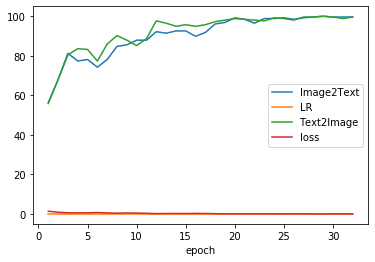

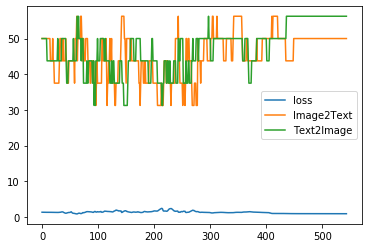

In [14]:

###### 读取训练日志


def load_train_outlog(out_log_path):
    import pandas as pd
    """ 解析 bash 训练命令生成 out_*.log 日志，获取train、valid 日志 """
    train_dt, valid_dt =[], []
    with open(out_log_path, 'r') as f:
        for i,line in enumerate(f.readlines()):
            line = line.strip()
            ele = line.split("|")
            if 'Image2Text Acc' in line:
                # print(line)
                if 'Global Steps' in line:
                    steps = ele[3].split(":")[-1].strip()
                    epoch = ele[4].split(":")[-1].strip()
                    loss = ele[5].split(":")[-1].strip()
                    Image2Text = ele[6].split(":")[-1].strip()
                    Text2Image = ele[7].split(":")[-1].strip()
                    lr = ele[10].split(":")[-1].strip()

                    train_dt.append({"steps": steps, "epoch": epoch, "loss": eval(loss), "Image2Text": eval(Image2Text), "Text2Image": eval(Text2Image), "LR": eval(lr)})
                elif 'Validation' in line:
                    steps = ele[3].split(":")[-1].strip()
                    loss = ele[4].split(":")[-1].strip()
                    Image2Text = ele[5].split(":")[-1].strip()
                    Text2Image = ele[6].split(":")[-1].strip()
                    valid_dt.append({"steps": steps, "loss": eval(loss), "Image2Text": eval(Image2Text), "Text2Image": eval(Text2Image)})

    train_dt = pd.DataFrame(train_dt)
    valid_dt = pd.DataFrame(valid_dt)

    return train_dt, valid_dt

out_log_path = "/data/1_qunosen/2022/res/CLIP/Chinese-CLIP/experiments/dhome3/out_2022-08-09-13-50-48.log"
out_log_path = '/data/1_qunosen/2022/res/CLIP/Chinese-CLIP/experiments/baidu/out_2022-08-11-06-17-36.log'
out_log_path = '/data/1_qunosen/2022/res/CLIP/Chinese-CLIP/experiments/baidu1/out_2022-08-11-07-52-34.log'
train_loss , valid_loss = load_train_outlog(out_log_path)
train_loss['epoch']= train_loss['epoch'].apply(lambda x: int(str(x).split()[0]))
train_loss.drop(columns='steps', inplace=True)
train_pdf = train_loss.pivot_table(index='epoch',  aggfunc='mean')
# train_loss.to_csv("/data/1_qunosen/2022/res/CLIP/Chinese-CLIP/tloss.csv", index=False)
train_pdf.plot()
valid_loss.plot()

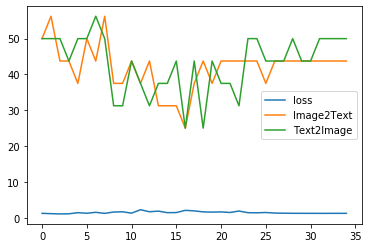

In [4]:
valid_loss.plot()

In [22]:

# # dataset_dir = "/data/1_qunosen/2022/res/CLIP/Chinese-CLIP/data/indoor"
# # dataset_dir = "/data/1_qunosen/2022/res/CLIP/clip/data/indoor"
# dataset_dir = "/data/1_qunosen/2022/res/CLIP/clip/data/indoor2"
# # 数据格式转化
# gen_cn_clip_data(train_indoor, dt_type='train', save_dir=dataset_dir)
# gen_cn_clip_data(test_indoor, dt_type='test', save_dir=dataset_dir)
# gen_cn_clip_data(valid_indoor, dt_type='valid', save_dir=dataset_dir)
# # 生成训练数据
# build_clip_data(dataset_dir)

out_dir = '/data/1_qunosen/2022/res/CLIP/clip_chinese_text_encoder/cn_datasets/baidu_spplit_set'
# get_cn_clip_df(baidu_df, out_dir)
train_df = pd.read_csv( os.path.join(out_dir, "train.csv") )
test_df = pd.read_csv( os.path.join(out_dir, "test.csv") )
valid_df = pd.read_csv(os.path.join(out_dir, "valid.csv"))

dataset_dir = "/data/1_qunosen/2022/res/CLIP/Chinese-CLIP/data/baidu"
# gen_cn_clip_data(train_df, dt_type='train', save_dir=dataset_dir)
# gen_cn_clip_data(test_df, dt_type='test', save_dir=dataset_dir)
# gen_cn_clip_data(valid_df, dt_type='valid', save_dir=dataset_dir)
# build_clip_data(dataset_dir)

28it [00:00, 24589.72it/s]
28it [00:00, 2459.18it/s]
4it [00:00, 5761.41it/s]
4it [00:00, 1284.04it/s]
3it [00:00, 4102.68it/s]

Finished serializing 28 train split pairs into /data/1_qunosen/2022/res/CLIP/clip/data/indoor2/lmdb/train/pairs.
Finished serializing 28 train split images into /data/1_qunosen/2022/res/CLIP/clip/data/indoor2/lmdb/train/imgs.
Finished serializing 4 valid split pairs into /data/1_qunosen/2022/res/CLIP/clip/data/indoor2/lmdb/valid/pairs.
Finished serializing 4 valid split images into /data/1_qunosen/2022/res/CLIP/clip/data/indoor2/lmdb/valid/imgs.



3it [00:00, 2049.33it/s]


Finished serializing 3 test split pairs into /data/1_qunosen/2022/res/CLIP/clip/data/indoor2/lmdb/test/pairs.
Finished serializing 3 test split images into /data/1_qunosen/2022/res/CLIP/clip/data/indoor2/lmdb/test/imgs.
done !


#### 训练

##### 加载模型

In [11]:
def model_init(model_dir = "/data/1_qunosen/2022/res/CLIP/Chinese-CLIP/experiments/dhome2"):
    """ 加载clip模型 """
    
    def convert_models_to_fp32(model):
        for p in model.parameters():
            p.data = p.data.float()
            if p.grad:
                p.grad.data = p.grad.data.float()
    
    gpu = 0
    vision_model, text_model = 'ViT-B-16', 'RoBERTa-wwm-ext-base-chinese'
    
    if os.path.isfile(model_dir) and str(model_dir).endswith('.pt'):
        model_path = model_dir
    else:
        model_path = os.path.join(model_dir, "checkpoints/epoch_latest.pt")
    
    vision_model_config_file = f"./training/model_configs/{vision_model}.json"
    text_model_config_file = f"./training/model_configs/{text_model}.json"

    with open(vision_model_config_file, 'r') as fv, open(text_model_config_file, 'r') as ft:
        model_info = json.load(fv)
        for k, v in json.load(ft).items():
            model_info[k] = v
    
    checkpoint = torch.load(model_path, map_location='cpu')
    start_epoch = checkpoint["epoch"]
    sd = checkpoint["state_dict"]
    if next(iter(sd.items()))[0].startswith('module'):
        sd = {k[len('module.'):]: v for k, v in sd.items()}
    
    model = CLIP(**model_info)
    convert_weights(model)
    torch.cuda.set_device(gpu)
    model.cuda(gpu)
    model.load_state_dict(sd)
    convert_models_to_fp32(model)
    model = model.eval()
    return model


def _preprocess_text(text):
    # adapt the text to Chinese BERT vocab
    text = text.lower().replace("“", "\"").replace("”", "\"")
    return text


def text2emb(text_input = '日式风格的客厅里有个电视柜'):
    """ 文本特征提取 """
    gpu = 0
    text_tokenizer = tokenize([_preprocess_text(text_input)], context_length= 24)
    with torch.no_grad():
        text_data = text_tokenizer.cuda(gpu, non_blocking=True)
        text_features = MODEL(None, text_data)
        text_features /= text_features.norm(dim=-1, keepdim=True)
        text_features = text_features.cpu().detach()
        return text_features


def to_tensor_img(resolution=224):
    def _convert_to_rgb(image):
        return image.convert('RGB')
    normalize = Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
    return Compose([ Resize((resolution, resolution), 
                     interpolation=Image.BICUBIC), 
                     _convert_to_rgb, ToTensor(), normalize, ])

def image2emb(img_path):
    gpu = 0
    _tenor = to_tensor_img()
    img = Image.open(img_path).convert('RGB')
    with torch.no_grad():
        t_img = _tenor(img).unsqueeze(0)
        images = t_img.cuda(gpu, non_blocking=True)
        image_features = MODEL(images, None)
        image_features /= image_features.norm(dim=-1, keepdim=True)
        image_features = image_features.cpu().detach()
        return image_features


def id2index(id, arrs):
    """ id: int --> int， 通过df索引返回id对应特征的索引 """
    return np.argwhere(arrs == id)[0][0]

def index2imgs(idx, df):
    tdf = df.iloc[idx]
    return tdf['filepath'].tolist(), tdf['caption_cn'].tolist()

def load_csv(csv_path):
    return pd.read_csv(csv_path)

def find_best_matches(text_features, photo_features, photo_ids, topk=3):
    
    def cos_sim1(text_features, photo_features, photo_ids, topk=3):
        text_features = text_features.numpy()
        photo_features = photo_features.numpy()
        similarities = (photo_features @ text_features.T).squeeze(1)
        best_photo_idx = (-similarities).argsort()
        return similarities[best_photo_idx[:topk]].tolist(), [photo_ids[i] for i in best_photo_idx[:topk]]

    def cos_sim2(text_features, photo_features, photo_ids, topk=3):
        
        top = torch.cosine_similarity(text_features, photo_features).topk(k=topk)
        indices = [photo_ids[i] for i in top.indices.numpy()]
        scores = top.values.numpy().tolist()
        
        return scores, indices
    
    return cos_sim2(text_features, photo_features, photo_ids, topk)
    


def text_search_images(text_query, df, imgs_embeddings, membs_index, topk=4):
    """ 文搜图 """

    txt_emb = text2emb(text_query)
    t2m_scores, t2m_indx = find_best_matches(txt_emb, imgs_embeddings, membs_index, topk=topk)
    t2m_imgfiles, t2m_tags = index2imgs(t2m_indx, df)
    t2m_imgnames = [os.path.basename(x) for x in t2m_imgfiles]
    
    print(f"t2m_indx: {t2m_indx} ")
    imgGallery(imglist=t2m_imgfiles, ids=t2m_imgnames, scores=t2m_scores, tags=t2m_tags)



def image_search_images(image_query, df, imgs_embeddings, membs_index, topk =4):
    """ 图搜图 """
    img_tags, img_names = None, None
    if isinstance(image_query, int):
        assert image_query <= max(df.index.values), f"图片编号应在：[{min(df.index.values)}, {max(df.index.values)}]"
        img_indx = image_query
        img_files = df.iloc[[img_indx]]['filepath'].tolist()
        img_names = [f"query:  {df.iloc[[0]]['file_name'].tolist()[0]}"]
        img_tags = df.iloc[[img_indx]]['caption_cn'].tolist()
        img_emb_index = id2index(image_query, membs_index)
        img_emb = imgs_embeddings[img_emb_index].unsqueeze(0)

    elif isinstance(image_query, str):
        assert os.path.exists(image_query), f"{image_query} 不存在。"
        img_files = [image_query]
        img_names = [f"query:  {os.path.basename(image_query)}"]
        img_emb = image2emb(image_query)
    
    
    imgGallery(imglist=img_files, ids=img_names, tags=img_tags)

    m2m_scores, m2m_indx = find_best_matches(img_emb, imgs_embeddings, membs_index, topk=topk)
    m2m_imgfiles, m2m_tags = index2imgs(m2m_indx, df)
    m2m_imgnames = [os.path.basename(x) for x in m2m_imgfiles]
    print(f"m2m_indx: {m2m_indx} ")

    print("结果： ")
    imgGallery(imglist=m2m_imgfiles, ids=m2m_imgnames, scores=m2m_scores, tags=m2m_tags)





def text_match_images(text_query, df, texts_embeddings, tembs_index, topk=4):
    """ 文搜索文，通过文映射到图片"""

    txt_emb = text2emb(text_query)
    t2t_scores, t2t_indx = find_best_matches(txt_emb, texts_embeddings, tembs_index, topk=topk)
    
    t2t_imgfiles, t2t_tags = index2imgs(t2t_indx, df)
    t2t_imgnames = [os.path.basename(x) for x in t2t_imgfiles]
    print(f"t2t_indx: {t2t_indx} ")

    # print(t2t_tags)
    imgGallery(imglist=t2t_imgfiles, ids=t2t_imgnames, scores=t2t_scores, tags=t2t_tags)


def content_search(image_query, text_query, df, imgs_embeddings, membs_index, topk=4, image_wight = 0.5):
    """ 图文混搜 """
    img_names, img_tags = None, None
    if isinstance(image_query, int):
        assert image_query <= max(df.index.values), f"图片编号应在：[{min(df.index.values)}, {max(df.index.values)}]"
        img_indx = image_query
        img_files = df.iloc[[img_indx]]['filepath'].tolist()
        img_names = [f"query: {df.iloc[[0]]['file_name'].tolist()[0]}"]
        img_tags = df.iloc[[img_indx]]['caption_cn'].tolist()
        img_emb_index = id2index(image_query, membs_index)
        img_emb = imgs_embeddings[img_emb_index].unsqueeze(0)
    
    elif isinstance(image_query, str):
        assert os.path.exists(image_query), f"{image_query} 不存在。"
        img_names = [f"query:  {os.path.basename(image_query)}"]
        img_files = [image_query]
        img_emb = image2emb(image_query)
        
    imgGallery(imglist=img_files, ids=img_names, tags=img_tags)

    search_features = img_emb
    if len(text_query) > 0:
        txt_emb = text2emb(text_query)
        search_features = txt_emb + img_emb * image_wight
        # search_features = torch.from_numpy(search_features)
        search_features /= search_features.norm(dim=-1, keepdim=True)
        
    
    c2m_scores, c2m_indx = find_best_matches(search_features, imgs_embeddings, membs_index, topk=topk)
    c2m_imgfiles, c2m_tags = index2imgs(c2m_indx, df)
    c2m_imgnames = [ os.path.basename(x) for x in c2m_imgfiles ]
    print(f"c2m_indx: {c2m_indx} ")

    print("结果： ")
    imgGallery(imglist=c2m_imgfiles, ids=c2m_imgnames, scores=c2m_scores, tags=c2m_tags)




def text_image_simi_matrix(df):
    """ 图文匹配相似度矩阵 """
    
    txts = df['caption_cn'].tolist()
    imgfiles = df["filepath"].tolist()
    
    txt_embs, img_embs = [], []
    for txt, img_path in zip(txts, imgfiles):
        txt_emb = text2emb(txt).squeeze(0).numpy()
        img_emb = image2emb(img_path).squeeze(0).numpy()
        txt_embs.append(txt_emb)
        img_embs.append(img_emb)

    txt_embs = torch.tensor(np.array(txt_embs))
    img_embs = torch.tensor(np.array(img_embs))

    txt_embs /= txt_embs.norm(dim=-1, keepdim=True)
    img_embs /= img_embs.norm(dim=-1, keepdim=True)
    similarity = txt_embs.cpu().numpy() @ img_embs.cpu().numpy().T

    cos_mxa, cos_min = np.max(similarity), np.min(similarity)
    cos_mxa = cos_mxa + 0.2 if cos_mxa < 0.8 else 1
    cos_min = cos_min - 0.2 if cos_min > 0.2 else 0

    count = len(txts)
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False 
    plt.figure(figsize=(20, 14))
    plt.imshow(similarity, vmin=cos_min, vmax=cos_mxa)
    plt.yticks(range(count), txts, fontsize=18), plt.xticks([]) #  plt.colorbar()
    
    for i, img_path in enumerate(imgfiles):
        img = Image.open(img_path)
        plt.imshow(img, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
    
    for x in range(similarity.shape[1]):
        for y in range(similarity.shape[0]):
            plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

    for side in ["left", "top", "right", "bottom"]:
        plt.gca().spines[side].set_visible(False)

    plt.xlim([-0.5, count - 0.5])
    plt.ylim([count + 0.5, -2])
    plt.title("文图匹配（相似度）", size=20)




# MODEL = model_init("/data/1_qunosen/2022/res/CLIP/Chinese-CLIP/experiments/indoor")
MODEL = model_init("/data/1_qunosen/2022/res/CLIP/Chinese-CLIP/experiments/baidu")


### 提取特征

In [13]:
# df_indoor = pd.concat([train_indoor, test_indoor, valid_indoor]).reset_index(drop=True)
# print(df_indoor.shape)
# df_indoor.head(3)

df_indoor = baidu_df.copy()
df_indoor

,file_name,caption,caption_cn,filepath
0,94a8f1e5bb3933204eb241fcb3ff9dfe.jpg,红色落地窗帘,红色落地窗帘,/data/1_qunosen/2022/res/CLIP/clip_chinese_tex...
1,6b5f0c5976555c6d0a931f9158e25ba0.jpg,"sun zero becca 节能金属扣眼窗帘 砖红色 40"" x 63"" 53386","sun zero becca 节能金属扣眼窗帘 砖红色 40"" x 63"" 53386",/data/1_qunosen/2022/res/CLIP/clip_chinese_tex...
2,7d8468afce98b757bd30f37da30be52e.jpg,欧式窗帘红色,欧式窗帘红色,/data/1_qunosen/2022/res/CLIP/clip_chinese_tex...
3,04c3458b1fddcb0ff81a99b57a2223cf.jpg,红色喜庆蕾丝中式客厅窗帘效果图,红色喜庆蕾丝中式客厅窗帘效果图,/data/1_qunosen/2022/res/CLIP/clip_chinese_tex...
4,94c10548670db012e5a2267db6f34df0.jpg,ucharge 遮光窗帘适用于卧室和起居室隔热孔环顶部窗帘 1 个窗格 红色,ucharge 遮光窗帘适用于卧室和起居室隔热孔环顶部窗帘 1 个窗格 红色,/data/1_qunosen/2022/res/CLIP/clip_chinese_tex...
...,...,...,...,...
274,0f4935de3d147b8fac126bdc37c16c36.jpg,3米沙发客厅加工,3米沙发客厅加工,/data/1_qunosen/2022/res/CLIP/clip_chinese_tex...
275,faeb1100e2ae5a4091bad9ddd741cd9c.jpg,倍丽雅地毯 商用条纹地毯 客厅茶几办公用地毯 满铺方形地毯,倍丽雅地毯 商用条纹地毯 客厅茶几办公用地毯 满铺方形地毯,/data/1_qunosen/2022/res/CLIP/clip_chinese_tex...
276,e04c103f1130f283e9ce1883a826a4c0.jpg,卡通可爱简约条纹厨房洗手间客厅长条床边地毯进门垫浴室防滑地垫,卡通可爱简约条纹厨房洗手间客厅长条床边地毯进门垫浴室防滑地垫,/data/1_qunosen/2022/res/CLIP/clip_chinese_tex...
277,feac2451fbca7c4931431590fe8bf2d2.jpg,现代简约客厅沙发黑色条纹地毯贴图,现代简约客厅沙发黑色条纹地毯贴图,/data/1_qunosen/2022/res/CLIP/clip_chinese_tex...


In [14]:
membs_index, imgs_embeddings, texts_embeddings = [], [], []
for indx, line in enumerate(df_indoor.itertuples()):
    img_path = line[4]
    txt = line[3]
    if os.path.exists(img_path):
        emb = image2emb(img_path).squeeze(0).numpy()
        temb = text2emb(txt).squeeze(0).numpy()
        imgs_embeddings.append(emb)
        texts_embeddings.append(temb)
        membs_index.append(indx)

membs_index = np.array(membs_index)
imgs_embeddings = np.array(imgs_embeddings)
texts_embeddings = np.array(texts_embeddings)
imgs_embeddings = torch.tensor(imgs_embeddings)
texts_embeddings = torch.tensor(texts_embeddings)

/home/user/anaconda3/lib/python3.7/site-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


In [186]:
# text_image_simi_matrix(df_indoor[:20])


In [268]:
# text_image_simi_matrix(df_indoor.iloc[[11, 28, 13, 30, 12, 16, 21, 8]])

In [25]:

text_query = "3个枝形吊灯"
# text_query = "厨房吊灯"
# text_match_images(text_query, df_indoor, texts_embeddings, membs_index, 8)
text_search_images(text_query, df_indoor, imgs_embeddings, membs_index, topk=4)

t2m_indx: [186, 187, 213, 194] 


In [26]:
# text_query = "红色的沙发"
text_query = "白色窗帘和红色沙发"
# text_match_images(text_query, df_indoor, texts_embeddings, membs_index, 4)
text_search_images(text_query, df_indoor, imgs_embeddings, membs_index, topk=4)

t2m_indx: [23, 238, 258, 244] 


#### 文搜图

In [27]:

# text_query = "厨房"
# text_query = "厨房的木地板"
# text_query = "枝形吊灯"
# text_query = "红色窗帘、白色墙面"
# text_query = "红色的墙"
text_query = "红色的沙发和白色的窗帘"

text_search_images(text_query, df_indoor, imgs_embeddings, membs_index, topk=4)


t2m_indx: [23, 238, 258, 233] 


In [33]:

text_query = "条纹地毯"

text_search_images(text_query, df_indoor, imgs_embeddings, membs_index, topk=4)

t2m_indx: [271, 262, 275, 268] 


In [45]:
df_indoor[(df_indoor['caption_cn'].str.contains('沙发')) & (df_indoor['caption_cn'].str.contains('窗帘'))]

,file_name,caption,caption_cn,filepath
23,fc97345f2a8124426bd1781b48558282.jpg,"红色的沙发搭配同色系的窗帘打造浓浓的美式风格,也适合在节庆期间","红色的沙发搭配同色系的窗帘打造浓浓的美式风格,也适合在节庆期间",/data/1_qunosen/2022/res/CLIP/clip_chinese_tex...


In [34]:
### laste_epoch.pt

text_query = "白色窗帘和红色沙发"
text_search_images(text_query, df_indoor, imgs_embeddings, membs_index, topk=4)




t2m_indx: [23, 238, 258, 244] 


In [51]:
text_query = "客厅的沙发"
text_match_images(text_query, df_indoor, texts_embeddings, membs_index, topk=4)

t2t_indx: [266, 258, 45, 233] 


##### 图文混搜

In [41]:

image_query = 9
text_query = '红色窗纱'
text_query = '白色窗纱'
text_query = '白色沙发'
content_search(image_query, text_query, df_indoor, imgs_embeddings, membs_index, topk=8, image_wight=0.2)

c2m_indx: [238, 242, 252, 258, 251, 243, 247, 248] 
结果： 
